#### LSTM 

In this context, a Long Short-Term Memory (LSTM) network is a specialized type of recurrent neural network (RNN) designed to capture and learn long-range dependencies and temporal patterns in sequential financial data, such as asset prices, returns, and technical indicators. Unlike traditional feedforward networks, LSTMs have memory cells and gating mechanisms that allow them to retain information across many time steps, making them particularly effective for modeling the dynamics of financial markets and predicting future trends.

When used for portfolio optimization, the LSTM receives as input a sequence of features (such as those transformed by PCA) over a lookback window for each asset. The network processes this temporal information to generate a vector of portfolio weights, dynamically adjusting allocations in response to evolving market conditions. This approach enables the model to learn complex, non-linear relationships between historical market behavior and optimal asset allocation, potentially outperforming static or linear strategies.

By leveraging LSTM architectures, we can achieve:

Dynamic portfolio allocation that adapts to changing market patterns.

Improved risk-adjusted returns, as the model can learn to anticipate and respond to market volatility and regime shifts.

Automation of investment decisions, reducing the influence of human bias and emotion.

Comprehensive evaluation, including metrics such as cumulative returns, volatility, Sharpe ratio, and maximum drawdown, to assess the effectiveness of the LSTM-based strategy compared to traditional benchmarks.

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
import psutil

# --- Utility Functions ---
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # in GB

def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
    return 0

class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self
    def __exit__(self, *args):
        self.end_time = time.time()
        self.duration = self.end_time - self.start_time

# --- Data Loading and Preprocessing ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5b-selected_features_dataset.csv')
# data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/1-combined_etfs.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
# features = ['Close', 'Open', 'High', 'returns', 'EMA_10', 'RSI_14', 'MACD',
            # 'ADX_14', 'DMI_plus_14', 'DMI_minus_14', 'treasury_10y',
            # 'nonfarm_payrolls', 'cpi', 'baa_yield']

features = ['returns']
lookback = 30

# Sequence creation
X_list, y_list, dates_list = [], [], []
all_dates = sorted(data['Date'].unique())
for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.append(asset_slice[features].values)
            else:
                valid = False
                break
        if valid:
            cur_idx = all_dates.index(cur_date)
            if cur_idx + 1 < len(all_dates):
                next_date = all_dates[cur_idx + 1]
                next_returns = []
                for asset in assets:
                    next_row = data[(data['Date'] == next_date) & (data['Ticker'] == asset)]
                    if not next_row.empty:
                        next_returns.append(next_row['Close'].values[0])
                    else:
                        valid = False
                        break
                if valid:
                    X_i = np.stack(X_i, axis=1)  # (lookback, n_assets, n_features)
                    X_list.append(X_i)
                    y_list.append(next_returns)
                    dates_list.append(cur_date)
X = np.array(X_list)  # (samples, lookback, n_assets, n_features)
y = np.array(y_list)
dates = np.array(dates_list)
print(f"Data shape: {X.shape}")

# --- PCA Dimensionality Reduction ---
samples, lb, n_assets, n_features = X.shape
X_flat = X.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
pca_dims = X_pca.shape[1]
X_pca_seq = X_pca.reshape(samples, lb, n_assets, pca_dims)
X_lstm = X_pca_seq.reshape(samples, lb, n_assets * pca_dims)
print(f"PCA-LSTM input shape: {X_lstm.shape}")

# --- LSTM Model Definition ---
class PortfolioLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, n_assets):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_assets)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step
        out = self.fc(out)
        return torch.softmax(out, dim=1)

# --- Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor = torch.tensor(X_lstm, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
split_idx = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]
train_dates, test_dates = dates[:split_idx], dates[split_idx:]

n_assets = len(assets)
input_dim = X_lstm.shape[2]
hidden_dim = 64
num_layers = 3

model = PortfolioLSTM(input_dim, hidden_dim, num_layers, n_assets).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# --- Training Loop and Evaluation ---
def sharpe_loss(portfolio_returns):
    return -torch.mean(portfolio_returns) / (torch.std(portfolio_returns) + 1e-6)

def evaluate_portfolio(model, X, y, dates, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    weights_history = []
    returns = []
    prev_weights = None
    with torch.no_grad():
        for i in range(len(X)):
            current_X = X[i].unsqueeze(0)
            current_y = y[i]
            weights = model(current_X)
            raw_return = torch.sum(weights * current_y).item()
            if prev_weights is not None:
                turnover = torch.sum(torch.abs(weights - prev_weights)).item()
                raw_return -= cost_rate * turnover
            portfolio_values.append(portfolio_values[-1] * (1 + raw_return))
            weights_history.append(weights.squeeze().cpu().numpy())
            returns.append(raw_return)
            prev_weights = weights.clone()
    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    ann_return = (portfolio_values[-1] / portfolio_values[0]) ** (252 / len(returns)) - 1
    ann_vol = np.std(returns) * np.sqrt(252)
    return {
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'cumulative_returns': portfolio_values,
        'weights': np.array(weights_history),
        'dates': dates
    }

print("\nTraining LSTM...")
train_start = time.time()
lstm_losses, train_sharpes = [], []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    weights = model(X_train)
    portfolio_returns = torch.sum(weights * y_train, dim=1)
    loss = sharpe_loss(portfolio_returns)
    mse_loss = criterion(weights, y_train)
    loss.backward()
    optimizer.step()
    lstm_losses.append(loss.item())
    train_sharpes.append(-loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Sharpe={-loss.item():.4f}, MSE={mse_loss.item():.6f}")
train_time = time.time() - train_start

# --- Evaluation ---
model.eval()
with torch.no_grad():
    test_weights = model(X_test)
    test_returns = torch.sum(test_weights * y_test, dim=1)
    test_mse = criterion(test_weights, y_test).item()
test_results = evaluate_portfolio(model, X_test, y_test, test_dates)
print("\nEvaluation Metrics:")
print(f"- Training time: {train_time:.2f} seconds")
print(f"- Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"- GPU memory used: {get_gpu_memory():.2f} GB")
print(f"- RAM usage: {get_memory_usage():.2f} GB")
print(f"- Test MSE: {test_mse:.6f}")
print(f"- Test Sharpe Ratio: {test_results['sharpe']:.4f}")
print(f"- Test Annualized Return: {test_results['annualized_return']:.2%}")
print(f"- Test Annualized Volatility: {test_results['annualized_vol']:.2%}")
print(f"- Test Max Drawdown: {test_results['max_drawdown']:.2%}")

# --- Save Results ---
results_df = pd.DataFrame({
    'Date': test_dates,
    'Cumulative_Return': test_results['cumulative_returns'][1:]
})
for i, asset in enumerate(assets):
    results_df[f'Weight_{asset}'] = test_results['weights'][:, i]
results_df.to_csv('lstm_portfolio_results.csv', index=False)
print("Results saved to lstm_portfolio_results.csv")


Data shape: (17784, 30, 8, 1)
PCA-LSTM input shape: (17784, 30, 8)

Training LSTM...
Epoch 0: Sharpe=5.5686, MSE=17640.687500
Epoch 10: Sharpe=6.5251, MSE=17642.097656
Epoch 20: Sharpe=13.5124, MSE=17645.460938
Epoch 30: Sharpe=20.8403, MSE=17644.677734
Epoch 40: Sharpe=25.3310, MSE=17644.382812
Epoch 50: Sharpe=25.9639, MSE=17644.294922
Epoch 60: Sharpe=26.1281, MSE=17644.287109
Epoch 70: Sharpe=26.2048, MSE=17644.273438
Epoch 80: Sharpe=26.3009, MSE=17644.269531
Epoch 90: Sharpe=26.4594, MSE=17644.267578

Evaluation Metrics:
- Training time: 238.82 seconds
- Device: CPU
- RAM usage: 1.35 GB
- Test MSE: 44607.460938
- Test Sharpe Ratio: 34.9979
- Test Annualized Return: inf%
- Test Annualized Volatility: 4135.69%
- Test Max Drawdown: nan%
Results saved to lstm_portfolio_results.csv


/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_69422/731180149.py:153: RuntimeWarning: invalid value encountered in subtract
  drawdown = (peak - portfolio_values) / peak


- LSTM Training Loss Curve


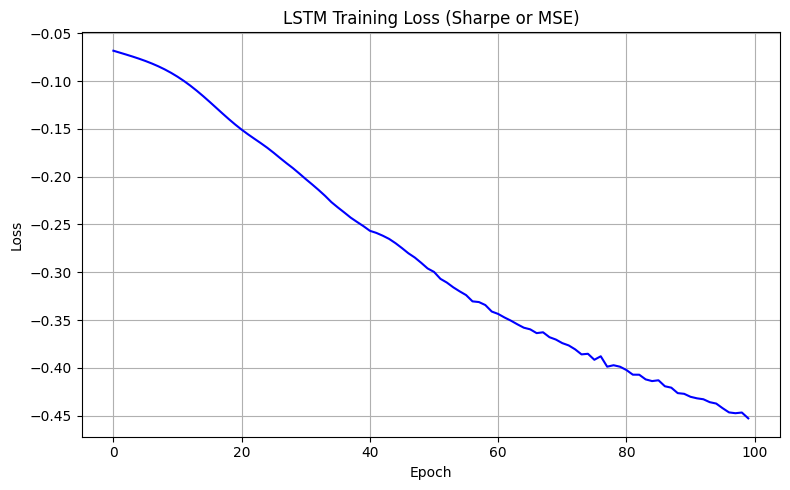

In [2]:
plt.figure(figsize=(8,5))
plt.plot(lstm_losses, color='blue')
plt.title('LSTM Training Loss (Sharpe or MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


- Test Portfolio Cumulative Returns

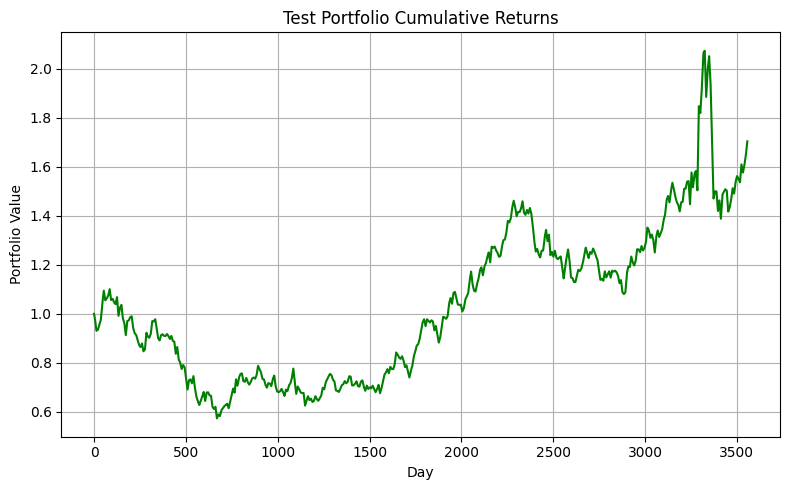

In [3]:
plt.figure(figsize=(8,5))
plt.plot(test_results['cumulative_returns'], color='green')
plt.title('Test Portfolio Cumulative Returns')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.tight_layout()
plt.show()


- Portfolio Weights Over Time (Stacked Area Chart)

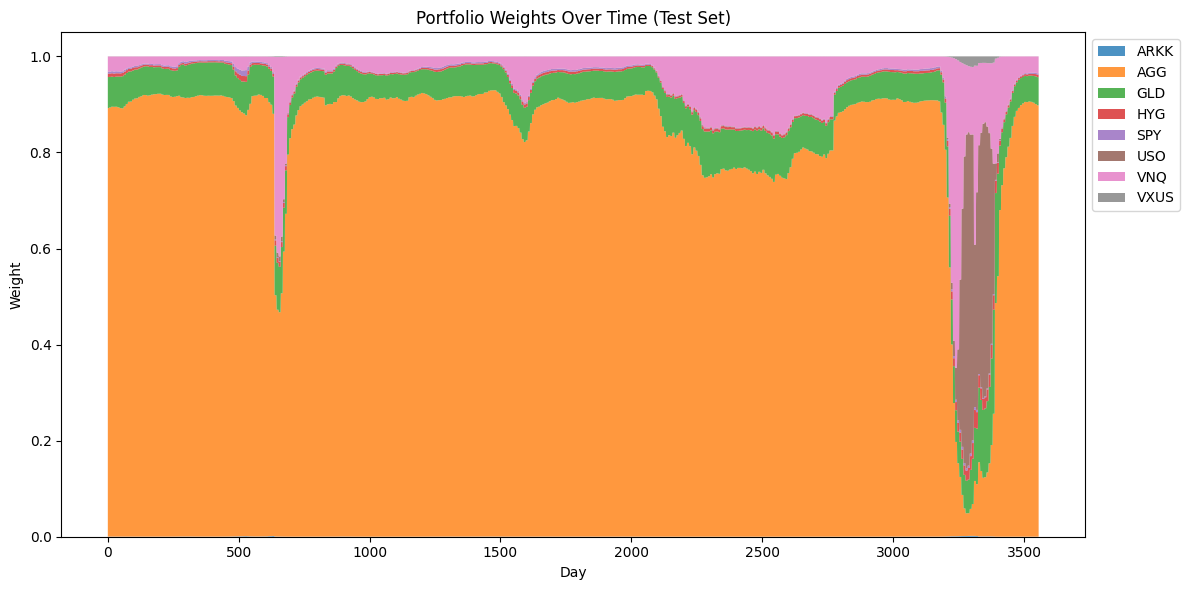

In [4]:
plt.figure(figsize=(12,6))
weights = np.array(test_results['weights'])  # shape: (timesteps, n_assets)
plt.stackplot(range(weights.shape[0]), weights.T, labels=assets, alpha=0.8)
plt.title('Portfolio Weights Over Time (Test Set)')
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


- Individual Asset Weights Over Time (Line Plot)

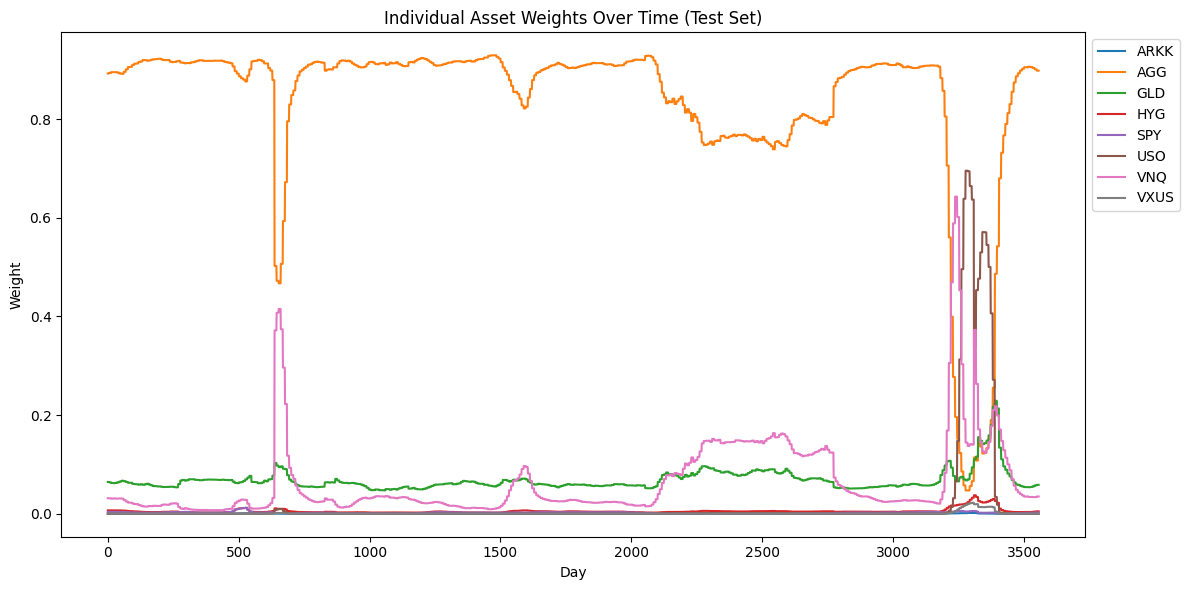

In [5]:
plt.figure(figsize=(12,6))
for i, asset in enumerate(assets):
    plt.plot(weights[:, i], label=asset)
plt.title('Individual Asset Weights Over Time (Test Set)')
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


- Bar Plot of Final Portfolio Weights

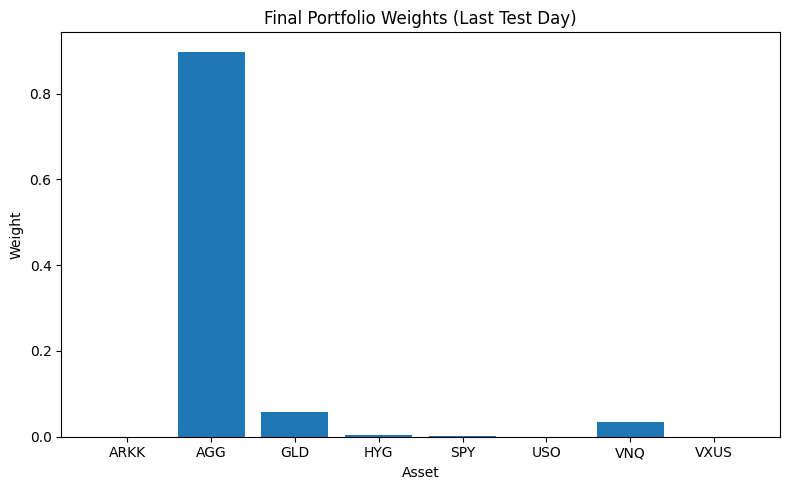

In [6]:
plt.figure(figsize=(8,5))
plt.bar(assets, weights[-1])
plt.title('Final Portfolio Weights (Last Test Day)')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.tight_layout()
plt.show()


- Performance Metrics Table (Text Output)

In [9]:
print("Test Performance Metrics:")
print(f"Sharpe Ratio: {test_results['sharpe']:.2f}")
print(f"Annualized Return: {test_results['annualized_return']:.2%}")
print(f"Annualized Volatility: {test_results['annualized_vol']:.2%}")
print(f"Max Drawdown: {test_results['max_drawdown']:.2%}")
print(f"Test MSE: {test_mse:.3f}")
    

Test Performance Metrics:
Sharpe Ratio: 0.04
Annualized Return: 3.85%
Annualized Volatility: 6.45%
Max Drawdown: 47.90%
Test MSE: 0.095


/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Epoch 1 | Loss: 0.027738
Epoch 2 | Loss: 0.027303
Epoch 3 | Loss: 0.027200
Epoch 4 | Loss: 0.027093
Epoch 5 | Loss: 0.026933
Epoch 6 | Loss: 0.026798
Epoch 7 | Loss: 0.026614
Epoch 8 | Loss: 0.026383
Epoch 9 | Loss: 0.026215
Epoch 10 | Loss: 0.026018
Epoch 11 | Loss: 0.025616
Epoch 12 | Loss: 0.025448
Epoch 13 | Loss: 0.025239
Epoch 14 | Loss: 0.025056
Epoch 15 | Loss: 0.024938
Epoch 16 | Loss: 0.024667
Epoch 17 | Loss: 0.024543
Epoch 18 | Loss: 0.024455
Epoch 19 | Loss: 0.024349
Epoch 20 | Loss: 0.024207

📊 Evaluation on Dummy Data
🔹 MSE:     0.022787
📈 Sharpe:  0.1208
📉 Sortino: 0.2039
⚠️  Calmar:  0.0071


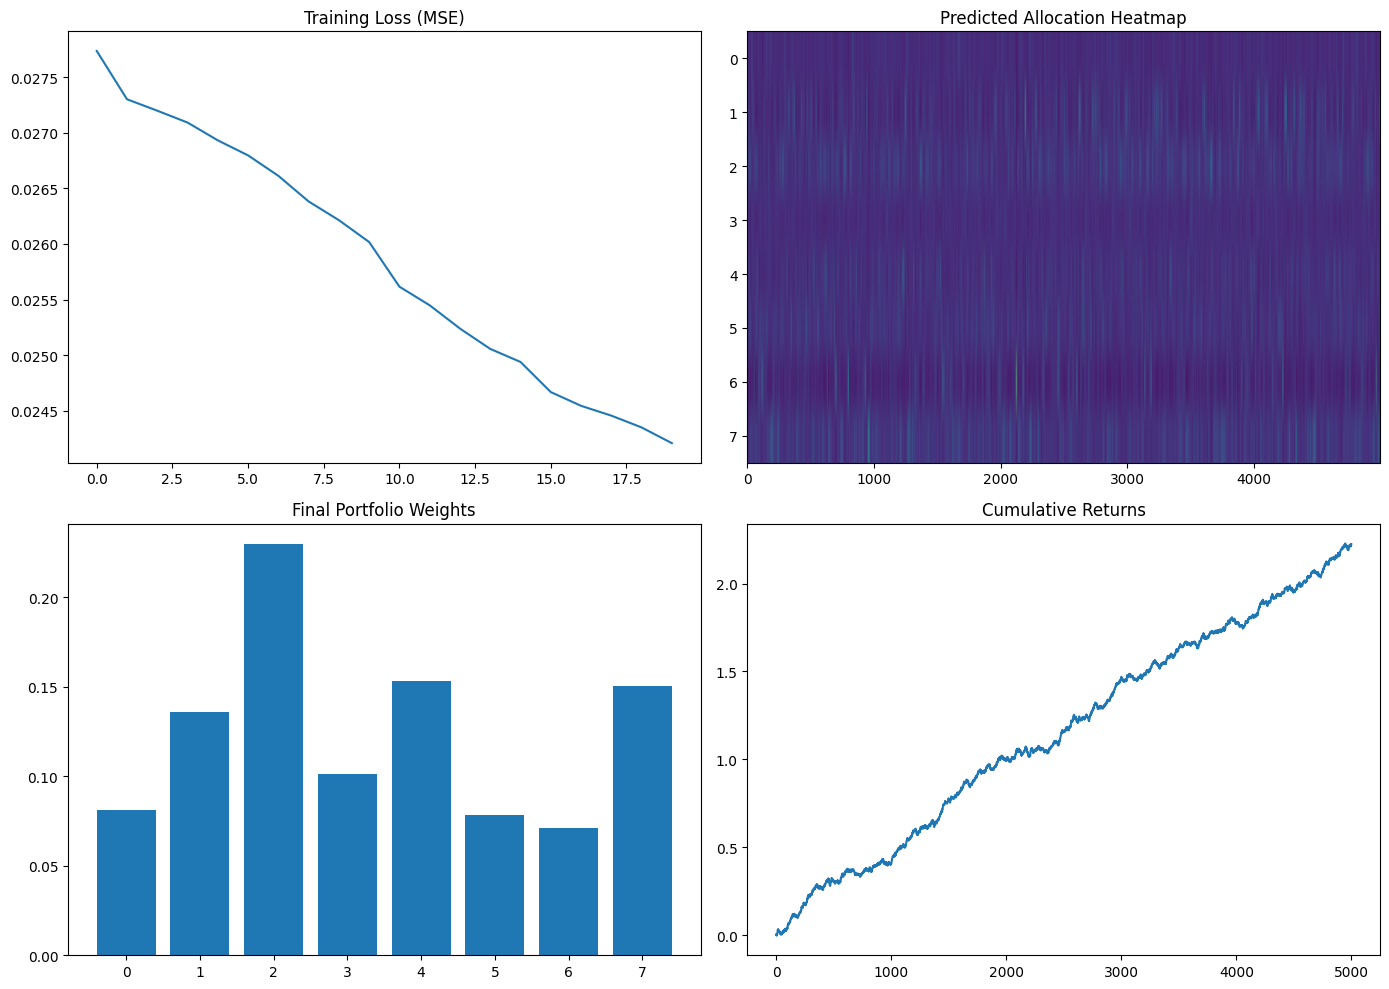

In [15]:
# === 🧠 DEMO WITH DUMMY DATA: TCN Portfolio Optimization ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

# === 1. Generate Dummy Data ===
n_samples = 5000
n_assets = 8
n_features = 16
sequence_length = 30
lookahead = 20

# Simulated daily prices (just for allocation calculation)
np.random.seed(100)
price_data = np.cumprod(1 + np.random.normal(0.0005, 0.01, (n_samples + lookahead + sequence_length, n_assets)), axis=0)
returns_df = pd.DataFrame(np.diff(np.log(price_data), axis=0), columns=[f"Asset{i+1}" for i in range(n_assets)])

# Simulated 16-feature input sequences (shape: samples, sequence_length, features)
X_dummy = np.random.randn(n_samples, sequence_length, n_features)

# === 2. Generate Target Allocations ===
def generate_dummy_target_allocations(returns_df, window=30, lookahead=20):
    targets = []
    for start in range(len(returns_df) - lookahead - window):
        future = returns_df.iloc[start + window : start + window + lookahead]
        mean_returns = future.mean()
        cov_matrix = future.cov()
        try:
            from pypfopt.efficient_frontier import EfficientFrontier
            from pypfopt.expected_returns import mean_historical_return
            from pypfopt.risk_models import CovarianceShrinkage
            ef = EfficientFrontier(mean_returns, cov_matrix)
            weights = ef.max_sharpe()
            w_arr = np.array([weights[k] for k in returns_df.columns])
        except:
            w_arr = np.ones(returns_df.shape[1]) / returns_df.shape[1]
        targets.append(w_arr)
    return np.array(targets)

y_dummy = generate_dummy_target_allocations(returns_df, window=sequence_length, lookahead=lookahead)
X_dummy = X_dummy[:len(y_dummy)]

# === 3. Prepare TCN Input Format ===
X_tensor = torch.tensor(X_dummy.transpose(0, 2, 1), dtype=torch.float32)
y_tensor = torch.tensor(y_dummy, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# === 4. Define TCN Model ===
class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size = chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation),
            Chomp1d(padding), nn.ReLU(), nn.Dropout(dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation),
            Chomp1d(padding), nn.ReLU(), nn.Dropout(dropout)
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2, output_size=8):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, 1, dilation, (kernel_size - 1) * dilation, dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        y = y[:, :, -1]
        return F.softmax(self.fc(y), dim=1)

# === 5. Train Model ===
model = TCN(num_inputs=n_features, num_channels=[32, 32, 32], output_size=n_assets)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.MSELoss()

losses = []
start = time.time()
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.6f}")

# === 6. Evaluation ===
model.eval()
with torch.no_grad():
    preds = model(X_tensor).numpy()
    true = y_tensor.numpy()
    mse = mean_squared_error(true, preds)

    # Simulate future returns
    future_ret = returns_df.iloc[sequence_length+lookahead:sequence_length+lookahead+len(preds)].values
    port_returns = (preds * future_ret).sum(axis=1)
    sharpe = port_returns.mean() / port_returns.std()
    sortino = port_returns.mean() / (port_returns[port_returns < 0].std() + 1e-8)
    drawdown = np.max(np.maximum.accumulate(np.cumsum(port_returns)) - np.cumsum(port_returns))
    calmar = port_returns.mean() / (drawdown + 1e-8)

print("\n📊 Evaluation on Dummy Data")
print(f"🔹 MSE:     {mse:.6f}")
print(f"📈 Sharpe:  {sharpe:.4f}")
print(f"📉 Sortino: {sortino:.4f}")
print(f"⚠️  Calmar:  {calmar:.4f}")

# === 7. Plots ===
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].plot(losses); axs[0, 0].set_title("Training Loss (MSE)")
axs[0, 1].imshow(preds.T, aspect='auto', cmap='viridis'); axs[0, 1].set_title("Predicted Allocation Heatmap")
axs[1, 0].bar(np.arange(n_assets), preds[-1]); axs[1, 0].set_title("Final Portfolio Weights")
axs[1, 1].plot(np.cumsum(port_returns)); axs[1, 1].set_title("Cumulative Returns")
plt.tight_layout(); plt.show()
